# attribution_audio
This notebook explores the `pyAudioAnalysis` library for voice clustering/speaker diarisation. This can be used to help the overall goal of dialogue attribution. With two-character dialogue scenes identified, we need to be able to identify each character and determine which one is speaking.

In [1]:
import pyAudioAnalysis.audioSegmentation
import numpy as np

# Speaker Diarization
`pyAudioAnalysis` has a function to automatically identify changes in speakers. We specify that there are two characters speaking. When a character starts speaking, they are listed as the speaker until the other character speaks, or until the end of the scene. (Periods of silence will be attributed to the last character who spoke.) 

Here's an example of a .wav file manually extracted from a two-character scene in *Hobbs and Shaw*, and converted into stereo format (from 5.1 surround sound) for use in `speaker_diarization()`.

In [2]:
audio_file = ('../extracted_audio/diner_stereo.wav')

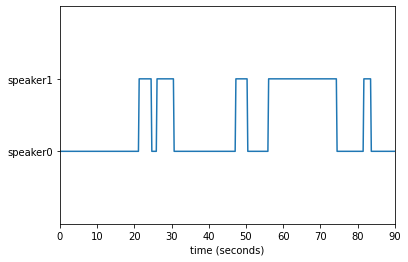

In [3]:
clusters = pyAudioAnalysis.audioSegmentation.speaker_diarization(audio_file, n_speakers=2, lda_dim=0, plot_res=True)

This is also available in a NumPy array. With the function's default parameters, the current (or last) speaker is noted every .2 seconds (or 5 times a second). This frequency can be modified by changing `mid_step` from its default value of .2.

In [4]:
clusters

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## Tuning Parameters
Here's another example from *Hobbs and Shaw*, with a scene with more back-and-forth and less monologue compared to the previous example. The first diarization uses the default parameters, while the second has the mid- and short-term windows and the mid_step shortened, all of which allow for more sampling, generating better results.

We'll take a closer look at the `clusters` list in the next section, and it's worth noting that halving the mid_step length doubles the amount of samples in `clusters`, to 10 samples per second.

In [5]:
audio_file = ('../extracted_audio/prison_stereo.wav')

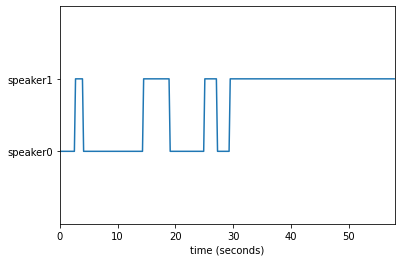

290
CPU times: user 13.5 s, sys: 681 ms, total: 14.2 s
Wall time: 4.64 s


In [6]:
%%time
# default parameters
clusters = pyAudioAnalysis.audioSegmentation.speaker_diarization(audio_file, n_speakers=2, lda_dim=0, plot_res=True)
print(len(clusters))

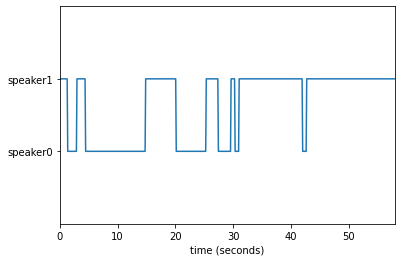

580 samples
CPU times: user 25.1 s, sys: 1.3 s, total: 26.4 s
Wall time: 8.88 s


In [7]:
%%time
# mid_window = .8, mid_step = .1, short_window = .02
clusters = pyAudioAnalysis.audioSegmentation.speaker_diarization(audio_file, n_speakers=2, mid_window=0.8, mid_step=0.1, short_window=0.02, lda_dim=0, plot_res=True)
print(len(clusters), 'samples')

While I manually specified that there were two characters to diarise, this prison scene actually has a third character, a prison guard who chimes in at 0:42 with a single two-word line "time's up". `speaker_diarization()` allows the user to specify 0 to indicate an unknown number of speakers, but it was unable to identify this third speaker, possibly because the line was so short.

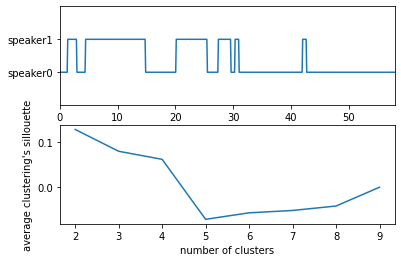

CPU times: user 28.3 s, sys: 1.33 s, total: 29.6 s
Wall time: 9.67 s


In [8]:
%%time
clusters = pyAudioAnalysis.audioSegmentation.speaker_diarization(audio_file, n_speakers=0, mid_window=.8, mid_step=0.1, short_window=0.02, lda_dim=0, plot_res=True)

Though we were unable to detect a third speaker, we may choose to not pre-specify two speakers. Though we're primarily working with two-character scenes, some of these scenes may have additional characters deliver lines.

## Voice Clustering
We can use the `clusters` list to assign (arbitrary) names to the voices. The list contains 10 samples per second, indicating the speaker (or who spoke last if no one is speaking). With two characters, this list is populated with a 0 or a 1. We can round the average of the ten samples, to a 0 or a 1. If there's a perfect 5-5 tie, we populate a dummy value.

Rather than populating the final list with 0s and 1s, we'll call them J and K. This is to avoid confusion around continuous data, and the fact that other clusters will be using 0 and 1 but may not necessarily be correlated.

For a 58-second scene, we end up with a list of length 58, which we can later insert into our frame DataFrame (with one row per second) for dialogue attribution.

In [9]:
speaker_list = []
x = 0
while x < len(clusters): 
    if sum(clusters[x:x+10]) == 5: # tiebreaker
        speaker_list.append(0)
    else:
        speaker_list.append(chr(int(round(np.mean(clusters[x:x+10])))+74)) # convert 0 and 1 to J and K
    x += 10

In [10]:
len(speaker_list)

58

In [11]:
speaker_list[0:5]

['J', 'K', 'K', 'J', 'K']

## Audible Sound Flag
We can also use the `pyAudioAnalysis` library to detect silence in the audio track. This immediately remediates an issue we just encountered: when conducting speaker diarization, exactly one character is listed as the speaker, even if no one is currently speaking.

However, finding pure silence in a film's audio mix is rare. Even if no one is speaking, we may still hear the score (music) or sound effects.

The `silence_removal()` function returns a list of times when there ISN'T silence.

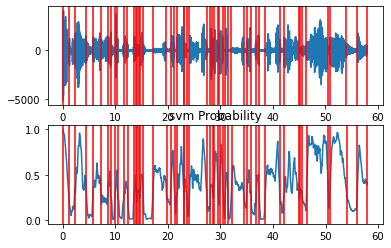

In [12]:
sampling_rate, signal = pyAudioAnalysis.audioBasicIO.read_audio_file(audio_file)
segments_with_sound = pyAudioAnalysis.audioSegmentation.silence_removal(signal, sampling_rate, st_win=0.05, st_step=0.025, smooth_window=0.5, weight=0.3, plot=True)

In [13]:
segments_with_sound

[[0.0, 1.125],
 [2.225, 4.4750000000000005],
 [5.7, 7.25],
 [8.525, 9.075000000000001],
 [9.9, 10.4],
 [11.625, 12.3],
 [13.525, 13.975000000000001],
 [14.175, 14.575000000000001],
 [14.700000000000001, 15.25],
 [17.125, 19.725],
 [20.525000000000002, 21.25],
 [21.675, 23.0],
 [23.075000000000003, 23.575000000000003],
 [24.1, 27.400000000000002],
 [28.075000000000003, 28.5],
 [28.725, 29.55],
 [29.825000000000003, 30.525000000000002],
 [30.925, 31.375],
 [32.1, 34.425000000000004],
 [35.025, 35.800000000000004],
 [36.85, 37.375],
 [38.550000000000004, 41.275000000000006],
 [42.125, 44.95],
 [45.125, 45.550000000000004],
 [46.400000000000006, 50.525000000000006],
 [50.825, 54.025000000000006],
 [56.025000000000006, 57.95]]

To use this in our frame DataFrame, we want to measure if there's audible sound at ANY time during the frame's duration (of one second). We loop through each frame duration and loop through `segments_with_sound` and see if there's sound at any point during the frame duration. But it isn't enough to check if there's audible sound at 8 seconds, we also check if there's sound at 8.25, 8.5, 8.75, and 8.99 seconds. If there's sound during any of these five times, we give the frame a flag for audible sound.

This size-58 list will also be used in our 58-frame DataFrame for dialogue attribution.

In [14]:
audible_sound = []

for frame in range(0, 58):
    sound_found = 0
    
    for segment in segments_with_sound:
        sound_start = segment[0]
        sound_end = segment[1]
        if sound_start <= frame and sound_end >= frame:
            sound_found = 1
        if sound_start <= frame + .25 and sound_end >= frame + .25:
            sound_found = 1
        if sound_start <= frame + .5 and sound_end >= frame + .5:
            sound_found = 1
        if sound_start <= frame + .75 and sound_end >= frame + .75:
            sound_found = 1
        if sound_start <= frame + .999 and sound_end >= frame + .999:
            sound_found = 1
        
    if sound_found:
        audible_sound.append(1)
    else:
        audible_sound.append(0)

In [15]:
len(audible_sound)

58

In [16]:
audible_sound[0:5]

[1, 1, 1, 1, 1]